#Importing important libraries

In [122]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv('/content/BA - Assignment Part 2 data set.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


## Data Dictionary
1. Clothing ID: ID related to that clothing product
2. Age: Age of the customer
3. Title:  Review title if specified
4. Review Text : Full review provided by the customer
5. Rating :  Rating provided byu the customer
6. Recommended IND: It a binary column , where 1 represents if the customer personally recommends that product
7. Positive Feedback Count : This columns represents the number of other customers who found the specific review helpful or positive in nature.
8. Division Name: Division under which that specific product resides in.
9. Category Name: Category under which that specific product resides in.
10. Class Name: Class given to a specific product.

In [5]:
#Finding out the number of categrorical and numerical features
num_cols, cat_cols = [],[]
numerical, categorical = 0,0
for feature in df.columns:
  if df.dtypes[feature] != 'O':
    numerical += 1
    num_cols.append(feature)
  else:
    categorical += 1
    cat_cols.append(feature)

print(f'There are {numerical} numerical features and {categorical} categorical features')
print('\nNumerical Features:')
print(num_cols)
print("\nCategorical Features:")
print(cat_cols)

There are 6 numerical features and 5 categorical features

Numerical Features:
['Unnamed: 0', 'Clothing ID', 'Age', 'Rating', 'Recommended IND', 'Positive Feedback Count']

Categorical Features:
['Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']


In [147]:
row, column = df.shape
print(f"There are \n'{row}' number of rows and \n'{column}' number of columns")

There are 
'23486' number of rows and 
'13' number of columns


In [7]:
# checking missing values
for col in df.columns:
  if df[col].isnull().sum() > 0:
    print(f" Column {col} has '{df[col].isnull().sum()}'  and\
 '{round((df[col].isnull().sum()/len(df))*100,2)}%' of missing values")


 Column Title has '3810'  and '16.22%' of missing values
 Column Review Text has '845'  and '3.6%' of missing values
 Column Division Name has '14'  and '0.06%' of missing values
 Column Department Name has '14'  and '0.06%' of missing values
 Column Class Name has '14'  and '0.06%' of missing values


In [148]:
# Preprocess the text data
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Ttokenizating the text
    tokens = word_tokenize(text)
    # Remove punctuation and non-alphabetic characters
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    return ' '.join(tokens)

In [28]:
df['cleaned_review'] = df['Review Text'].apply(preprocess_text)
df["cleaned_review"]

0              absolutely wonderful silky sexy comfortable
1        love dress sooo pretty happened find store gla...
2        high hopes dress really wanted work initially ...
3        love love love jumpsuit fun flirty fabulous ev...
4        shirt flattering due adjustable front tie perf...
                               ...                        
23481    happy snag dress great price easy slip flatter...
23482    reminds maternity clothes soft stretchy shiny ...
23483    fit well top see never would worked glad able ...
23484    bought dress wedding summer cute unfortunately...
23485    dress lovely platinum feminine fits perfectly ...
Name: cleaned_review, Length: 23486, dtype: object

In [29]:
stop_words = set(stopwords.words('english'))


In [109]:
"""Conduct Vader sentiment analysis, SentimentIntensityAnalyser() uses a module called VADER (Valend Aware
Dictionary andsEntiment Reasoner) which specially accustomed to sentiments expressed over social media.
It analyses and gives score ranging from -1 to 1. -1 being negative and 1 being positive and 0 being neutral.
This score is known as compound score."""
sia = SentimentIntensityAnalyzer()
df['sentiments'] = df['cleaned_review'].apply(lambda x: sia.polarity_scores(x))


In [110]:
#outputing df["sentiments"]
df["sentiments"]

0        {'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'comp...
1        {'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'comp...
2        {'neg': 0.04, 'neu': 0.721, 'pos': 0.24, 'comp...
3        {'neg': 0.171, 'neu': 0.185, 'pos': 0.644, 'co...
4        {'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp...
                               ...                        
23481    {'neg': 0.1, 'neu': 0.284, 'pos': 0.616, 'comp...
23482    {'neg': 0.116, 'neu': 0.564, 'pos': 0.32, 'com...
23483    {'neg': 0.099, 'neu': 0.48, 'pos': 0.42, 'comp...
23484    {'neg': 0.048, 'neu': 0.598, 'pos': 0.355, 'co...
23485    {'neg': 0.0, 'neu': 0.338, 'pos': 0.662, 'comp...
Name: sentiments, Length: 23486, dtype: object

In [111]:
#dropping the compund key and value pair out of sentiments columns
for i in range(len(df["sentiments"])):
  if 'compound' in df["sentiments"][i]:
    df["sentiments"][i].pop('compound')

In [112]:
#outputing df["sentiments"]
df["sentiments"]

0          {'neg': 0.0, 'neu': 0.154, 'pos': 0.846}
1          {'neg': 0.0, 'neu': 0.492, 'pos': 0.508}
2          {'neg': 0.04, 'neu': 0.721, 'pos': 0.24}
3        {'neg': 0.171, 'neu': 0.185, 'pos': 0.644}
4          {'neg': 0.0, 'neu': 0.494, 'pos': 0.506}
                            ...                    
23481      {'neg': 0.1, 'neu': 0.284, 'pos': 0.616}
23482     {'neg': 0.116, 'neu': 0.564, 'pos': 0.32}
23483      {'neg': 0.099, 'neu': 0.48, 'pos': 0.42}
23484    {'neg': 0.048, 'neu': 0.598, 'pos': 0.355}
23485      {'neg': 0.0, 'neu': 0.338, 'pos': 0.662}
Name: sentiments, Length: 23486, dtype: object

In [113]:
#Getting the dominant sentiment out of the sentiment polarity
for i in range(len(df["sentiments"])):
 df["sentiments"][i] = max(df["sentiments"][i], key= lambda k:df["sentiments"][i][k])

<ipython-input-113-3d3b4f75b4f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiments"][i] = max(df["sentiments"][i], key= lambda k:df["sentiments"][i][k])


In [52]:
# Identify key themes in positive and negative feedback
positive_reviews = df[df['sentiment_category'] == 'positive']['cleaned_review']
negative_reviews = df[df['sentiment_category'] == 'negative']['cleaned_review']

print("List of Positive Reviews :")
print(positive_reviews)

print("\n\nList of Negative Reviews: ")
print(negative_reviews)

List of Positive Reviews :
0              absolutely wonderful silky sexy comfortable
1        love dress sooo pretty happened find store gla...
2        high hopes dress really wanted work initially ...
3        love love love jumpsuit fun flirty fabulous ev...
4        shirt flattering due adjustable front tie perf...
                               ...                        
23481    happy snag dress great price easy slip flatter...
23482    reminds maternity clothes soft stretchy shiny ...
23483    fit well top see never would worked glad able ...
23484    bought dress wedding summer cute unfortunately...
23485    dress lovely platinum feminine fits perfectly ...
Name: cleaned_review, Length: 20371, dtype: object


List of Negative Reviews: 
77       zipper broke piece first time wore disappointi...
110      thin poor quality especially price felt like t...
191      minimally torn whether return ultimately going...
214      skirt received little blue green mostly white ...
394     

## Visualizations

<Figure size 600x600 with 0 Axes>

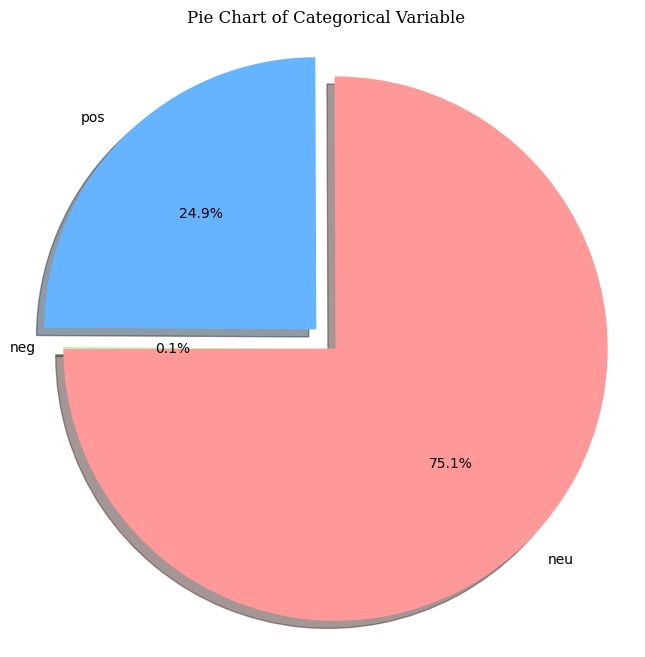

'plt.figure(figsize=(10, 8))\nsns.countplot(data=df, x="sentiments", hue = "sentiments")\nplt.title("Distribution of Reviews Based in Sentiments")'

In [143]:
plt.figure(figsize=(6,6))
sentiment_counts = df['sentiments'].value_counts(normalize=True)
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0, 0.1, 0)
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',\
        colors = colors,explode=explode,shadow=True, startangle=180)
plt.title('Pie Chart of Categorical Variable', fontfamily='serif')
plt.axis("equal")
plt.show()
"""plt.figure(figsize=(10, 8))
sns.countplot(data=df, x="sentiments", hue = "sentiments")
plt.title("Distribution of Reviews Based in Sentiments")"""

In [130]:
df["sentiments"].value_counts()

neu    17628
pos     5838
neg       20
Name: sentiments, dtype: int64

### Observation
In this case, the analysis indicates a prime majority of neutral sentiments,which does not sound unusual given typical consumer response patterns. However, this means there are almost zero negative reviews which needs to be investigated further.

Two potential explanations present themselves:

1. A misclassification may have occurred, meaning reviews with negative sentiment were accidentally labeled as neutral.
2. It could be a question of the intensity of the negative sentiment that needs exploration.

I'm planning to sift through reviews of all feedback with ratings less than two. I'm going to pick these at random to test this hypothesis.

In [145]:
#View it in the interactive table form, However I have attached a screenshot below
df[df["Rating"] <= 2][["Review Text","Rating","Recommended IND","sentiments"]]

,Review Text,Rating,Recommended IND,sentiments
5,"I love tracy reese dresses, but this one is no...",2,0,neu
22,"First of all, this is not pullover styling. th...",2,0,neu
26,I have been waiting for this sweater coat to s...,2,0,neu
33,"I ordered this 3 months ago, and it finally ca...",2,0,neu
56,I am pregnant and i thought this would be a gr...,2,0,neu
...,...,...,...,...
23406,I was very excited to find a fun and lightweig...,1,0,neu
23424,Before i ordered this i noted the other review...,2,0,neu
23427,What drew me to this shirt was the beautiful s...,2,0,neu
23437,This dress is so cute in the photo and fit tru...,2,0,neu


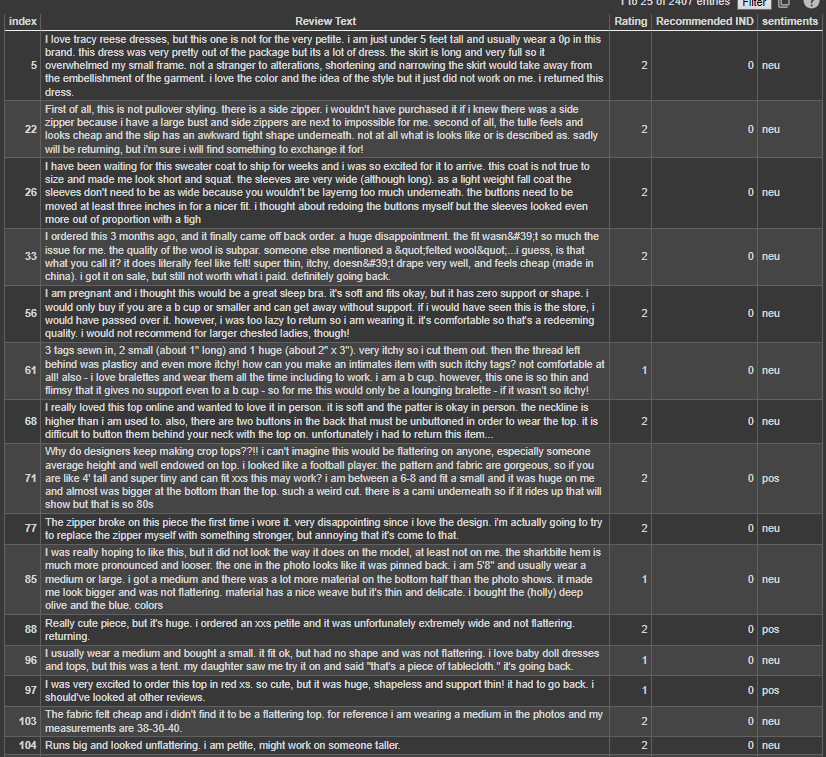

In [146]:
df[df["sentiments"] == "neg"][["Review Text","Rating","Recommended IND","sentiments"]]

,Review Text,Rating,Recommended IND,sentiments
588,Fits very strange. odd cut. does not look well...,2,0,neg
1341,I'm so incredibly disappointed. the dress is b...,1,0,neg
1358,Very disappointed. the cutouts started to rip ...,1,0,neg
2880,Nice top that can be worn alone or underneath ...,5,1,neg
3067,"Just didnt like the fit. it ""puffed out"" in fr...",3,0,neg
3502,I loved this top so much i bought it in both c...,4,1,neg
3777,Material is too thin and quality is poor,1,0,neg
5114,"What a disappointment and for the price, it's ...",1,0,neg
6296,"Awful color, horribly wrinkled and just a mess...",2,0,neg
7225,So disappointed! beautiful dress in the photog...,1,0,neg


# Conclusion
- Upon careful analysis of customer feedback, it can be seen that the second hypothesis stands validated. Reviews with lower ratings, characterized by a mismatch between the product features and customer expectations, are predominantly inconsistent with the quality of the product. In fact, this does not necessarily mean that the product quality was inferior.

- Further, a detailed sentiment analysis of the 20 reviews categorized as negative reveals a uniform feeling of dissatisfaction. The uniform sentiment of unhappiness, experienced by all the reviewers, shows a complete absence of customer satisfaction for the products in question.